In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, ICRS
from astropy import units as u
from modules.velocity_transformations import equatorial_UVW
from Distant_SigMA.SigMA.SigMA import SigMA

# Generate mock data

In [4]:
# Plotting related stuff
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:grey']
zorders = [2, 2, 2, 2, 2, 1]
alphas = [0.9, 0.9, 0.9, 0.9, 0.9, 0.3]
log = True

In [5]:
# Create 6D Gaussian data
np.random.seed(42) 
n = 1000
X_bg = (np.random.rand(n*5, 6) - 0.5) * 50 #background dataset of random points uniformly distributed 6D

mu = np.array([-5, 5, 5, 5, -5, 5]) #first 3 for average position of the Cluster in 3D(XYZ). Last 3 for average velocities in (VxVyVz)
c_xx = c_yy = 20 #Variance of the average in x and y.
c_xy = 15 
c_zz = 3
c_uvw = 1
cov = np.diag([c_xx, c_yy, c_zz, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy #makes positive correlation of x and y
# Add signal
X_sig_1 = np.random.multivariate_normal(mu, cov, n//2) #generate n/2 data points based on mu and cov

# Second cluster
mu_2 = np.array([5, -5, -5, -5, 5, -5])
c_xx_2 = c_yy = 20
c_xy_2 = -15
c_zz_2 = 3
cov = np.diag([c_xx_2, c_yy, c_zz_2, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy_2
X_sig_2 = np.random.multivariate_normal(mu_2, cov, n//2)

# Additional clusters' parameters
# Cluster 3
mu_3 = np.array([-12, 10, -10, -10, 15, -18])
c_xx_3 = c_yy_3 = 25 # More spread in X-Y plane
c_xy_3 = 10
c_zz_3 = 4
cov_3 = np.diag([c_xx_3, c_yy_3, c_zz_3, c_uvw, c_uvw, c_uvw])
cov_3[0, 1] = cov_3[1, 0] = c_xy_3
X_sig_3 = np.random.multivariate_normal(mu_3, cov_3, n//2)

# Cluster 4
mu_4 = np.array([-11, -10, 13, -7, -7, 18])
c_xx_4 = c_yy_4 = 30
c_xy_4 = -12
c_zz_4 = 5
cov_4 = np.diag([c_xx_4, c_yy_4, c_zz_4, c_uvw, c_uvw, c_uvw])
cov_4[0, 1] = cov_4[1, 0] = c_xy_4
X_sig_4 = np.random.multivariate_normal(mu_4, cov_4, n//2)

# Cluster 5
mu_5 = np.array([10, 10, 15, 10, -15, -20])
c_xx_5 = c_yy_5 = 32
c_xy_5 = 8
c_zz_5 = 6
cov_5 = np.diag([c_xx_5, c_yy_5, c_zz_5, c_uvw, c_uvw, c_uvw])
cov_5[0, 1] = cov_5[1, 0] = c_xy_5
X_sig_5 = np.random.multivariate_normal(mu_5, cov_5, n//2)

X = np.concatenate([X_bg, X_sig_1, X_sig_2, X_sig_3, X_sig_4, X_sig_5], axis=0) #5000 bg stars, and 5*500 cluster stars
labels = np.concatenate([np.zeros(n*5), np.ones(n//2), np.ones(n//2)*2, np.ones(n//2)*3, np.ones(n//2)*4, np.ones(n//2)*5])

df = pd.DataFrame(X, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
# Transform to spherical coordinates
gal_coords = Galactic(
    u=df.x.values * u.pc,
    v=df.y.values * u.pc,
    w=df.z.values * u.pc,
    # velocities UVW
    U=df.vx.values * u.km / u.s,
    V=df.vy.values * u.km / u.s,
    W=df.vz.values * u.km / u.s,
    representation_type="cartesian",
    # Velocity representation
    differential_type="cartesian",
)
# transform to ICRS
icrs_coords = gal_coords.transform_to(ICRS())
icrs_coords.representation_type = "spherical"

ra = icrs_coords.ra.value
dec = icrs_coords.dec.value
dist = icrs_coords.distance.value
pmra = icrs_coords.pm_ra.value * np.cos(np.deg2rad(dec))
pmdec = icrs_coords.pm_dec.value
rv_calc = icrs_coords.radial_velocity.value

df['ra'] = ra
df['dec'] = dec
df['dist'] = dist
df['pmra'] = pmra
df['pmdec'] = pmdec
df['radial_velocity'] = rv_calc

df['vt_ra'] = df.pmra * df.dist * 4.74
df['vt_dec'] = df.pmdec * df.dist * 4.74

idx_cluster_1 = np.where(labels==1)[0]
idx_cluster_2 = np.where(labels==2)[0]
idx_cluster_3 = np.where(labels==3)[0]
idx_cluster_4 = np.where(labels==4)[0]
idx_cluster_5 = np.where(labels==5)[0]
idx_bg = np.where(labels==0)[0]

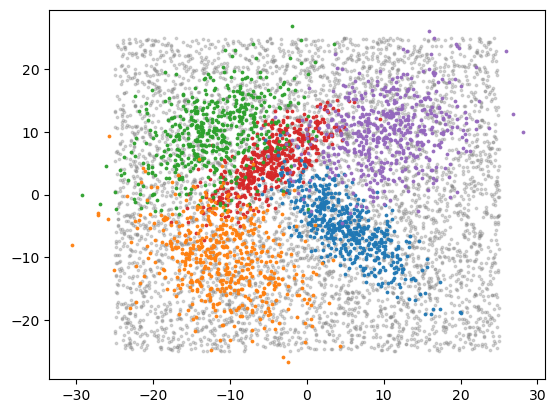

In [6]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'vx', 'vy'
#x_col, y_col = 'vt_ra', 'vt_dec'
#x_col, y_col = 'pmra', 'pmdec'
for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_cluster_3, idx_cluster_4, idx_cluster_5, idx_bg], alphas, colors, zorders): 
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)

In [7]:
U, V, W = equatorial_UVW(
    ra,
    dec,
    pmra,
    pmdec,
    rv_calc,
    dist,
)
# Check if the transformation is correct
np.allclose(U, df.vx.values, atol=1e-1), np.allclose(V, df.vy.values, atol=1e-1), np.allclose(W, df.vz.values, atol=1e-1)
print(df)
df.to_csv('data.csv', index=False)


              x          y          z         vx         vy         vz  \
0     -6.272994  22.535715  11.599697   4.932924 -17.199068 -17.200274   
1    -22.095819  18.308807   5.055751  10.403629 -23.970775  23.495493   
2     16.622132 -14.383044 -15.908752 -15.829775  -9.787888   1.237822   
3     -3.402749 -10.438543   5.592645 -18.025307 -10.392768  -6.681908   
4     -2.196501  14.258798 -15.016311   0.711722   4.620728 -22.677479   
...         ...        ...        ...        ...        ...        ...   
7495   0.318430   0.648008  14.767137  10.876024 -15.135884 -18.447722   
7496   5.940312  12.321013  16.776978   8.326091 -16.844013 -20.403112   
7497  18.546338  17.914509   9.237268  10.856226 -14.866233 -20.159990   
7498   4.620124  10.868567  16.013856   9.148356 -15.105983 -20.323542   
7499  14.467780   3.492152  17.611243  10.321478 -14.846155 -20.956594   

              ra        dec       dist        pmra       pmdec  \
0     281.680238  74.477071  26.110571   59.7

# Apply TreeSigMA

In [9]:
from TreeSigMA import TreeSigMAWithHierarchy  

knn_list=[15, 20, 25, 30]
cluster_features=['x', 'y', 'z']
sigma_kwargs = dict(
        nb_resampling=0,
        max_knn_density=int(np.max(knn_list)+1),
        beta=0.99,
        knn_initcluster_graph=35
    )

# Initialize TreeSigMA
tree_sigma = TreeSigMAWithHierarchy(
    data=df,
    cluster_features=cluster_features,
    **sigma_kwargs
)

# Run the SigMA clustering and build the hierarchy
print("Running TreeSigMA clustering...")
alpha_values = tree_sigma.run()
print("Clustering completed. Alpha values:", alpha_values)

# Build hierarchy 
print("\nBuilding hierarchy...")
tree_sigma.build_hierarchy()
print("Hierarchy built.")

# Traverse the tree
print("\nTop-down traversal:")
for node in tree_sigma.hierarchy.traverse_top_down():
    print(f"Node ID: {node.node_id}, Parent: {node.parent.node_id if node.parent else None}, "
          f"Children: {[child.node_id for child in node.children]}") # evt. , Data: {node.data}

print("\nBottom-up traversal:")
for node in tree_sigma.hierarchy.traverse_bottom_up():
    print(f"Node ID: {node.node_id}, Parent: {node.parent.node_id if node.parent else None}, "
          f"Children: {[child.node_id for child in node.children]}") # evt. , Data: {node.data}

# Access a specific node and analyze
print("\nInspecting a specific node...")
node_id = list(tree_sigma.hierarchy.nodes.keys())[0]  # Pick the desired node ID
node = tree_sigma.hierarchy.nodes[node_id]
print(f"Node ID: {node.node_id}")
print(f"Parent ID: {node.parent.node_id if node.parent else 'Root'}")
print(f"Children IDs: {[child.node_id for child in node.children]}")
#print(f"Data: {node.data}")

# Example: Analyzing the leaves
print("\nAnalyzing leaves:")
leaves = [node for node in tree_sigma.hierarchy.traverse_top_down() if node.is_leaf()]
for leaf in leaves:
    print(f"Leaf ID: {leaf.node_id}")

Performing gradient ascend using a 20-NN density estimation.
Running TreeSigMA clustering...
Clustering completed. Alpha values: [2.7200464103316335e-14, 8.358314040890491e-13, 7.849489391809072e-10, 0.008350465821492625, 0.017127265996220442, 0.024698097782602402, 0.03752241188654126, 0.04748529519762862, 0.07662375372192787, 0.10769685157837172, 0.12792206847670234, 0.14806420550879157, 0.1663054183057111, 0.1865651302903229, 0.19707690418024099]

Building hierarchy...
Adding node 5485_2.7200464103316335e-14 (original label 5485) with parent virtual_root, alpha 2.7200464103316335e-14
Adding node 5701_2.7200464103316335e-14 (original label 5701) with parent virtual_root, alpha 2.7200464103316335e-14
Adding node 5485_8.358314040890491e-13 (original label 5485) with parent 5485_2.7200464103316335e-14, alpha 8.358314040890491e-13
Adding node 5701_8.358314040890491e-13 (original label 5701) with parent 5701_2.7200464103316335e-14, alpha 8.358314040890491e-13
[[0.    0.451]]
Adding node 64

# Plot the Hierarchy

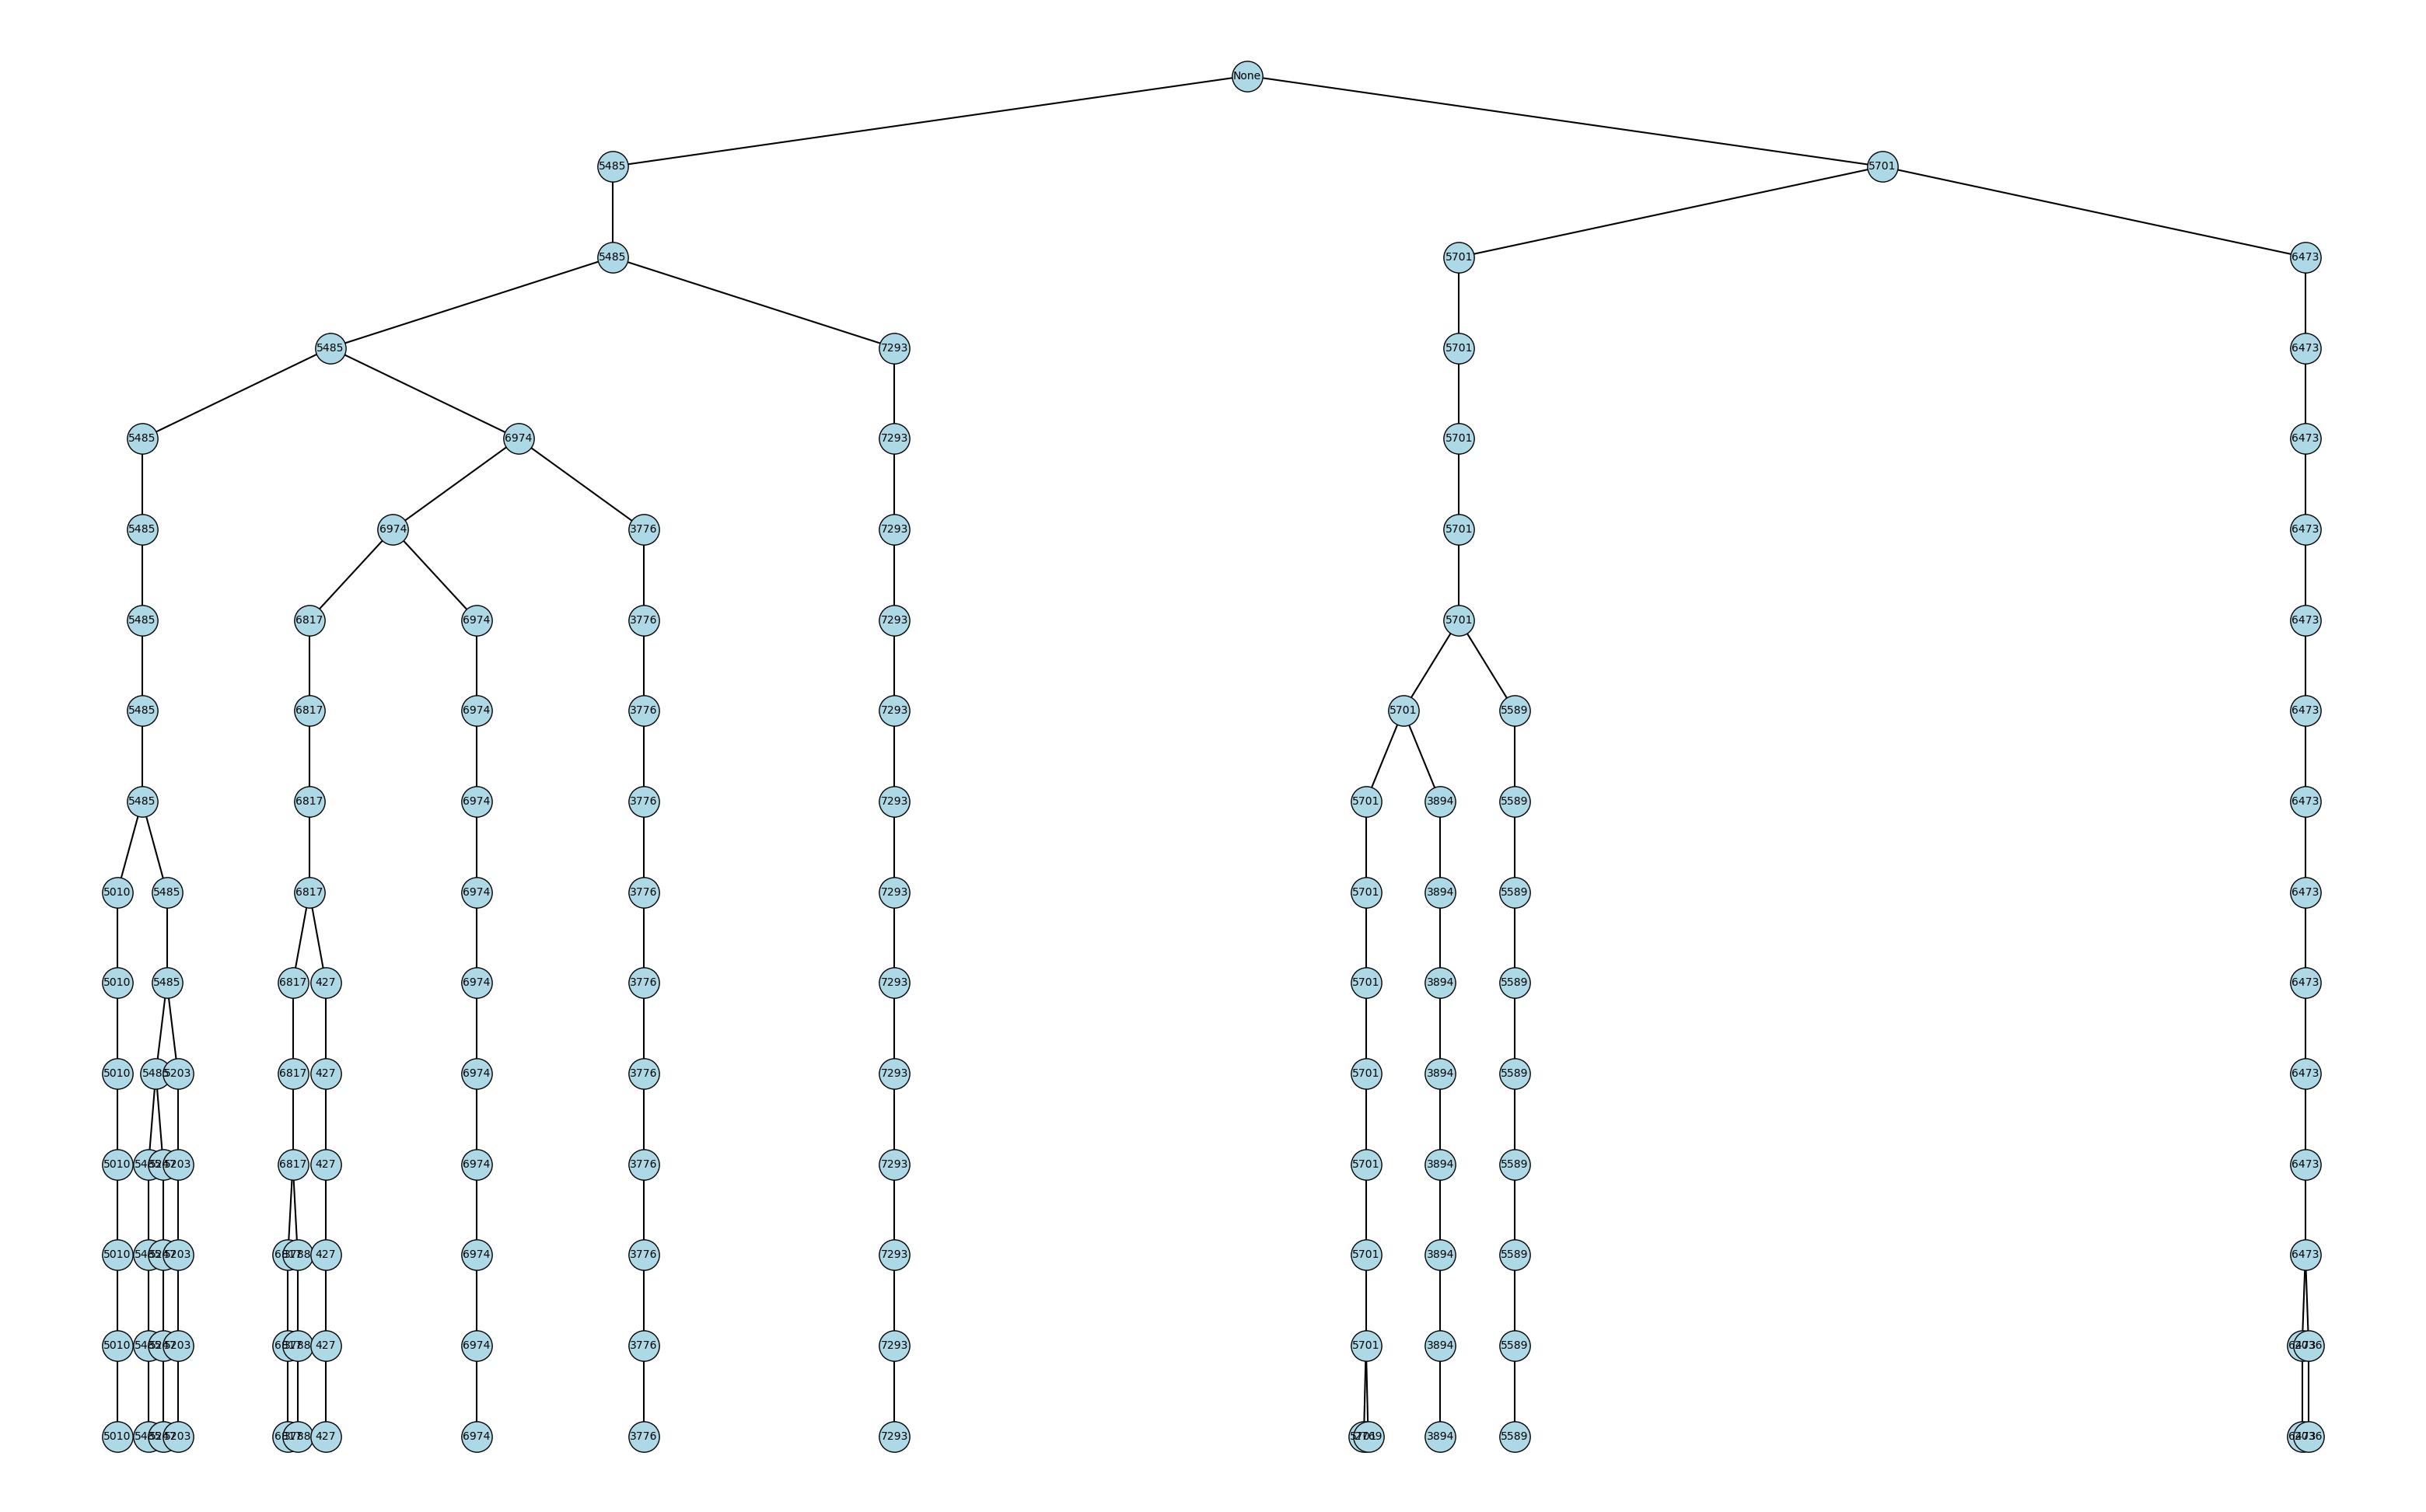

In [11]:
def plot_tree(node, x=0, y=0, level=0, x_spacing=1.5, y_spacing=1.5, node_positions=None, parent_positions=None, parent=None):
    """
    Recursively plot tree structure
    
    Args:
        node (TreeNode): The current node to plot.
        x (float): X-coordinate of the current node.
        y (float): Y-coordinate of the current node.
        level (int): Current level in the tree.
        x_spacing (float): Horizontal spacing between nodes.
        y_spacing (float): Vertical spacing between levels.
        node_positions (dict): Dictionary to store node positions for plotting.
        parent_positions (dict): Dictionary to store parent positions for edges.
        parent (tuple): Position of the parent node.
    """
    if node_positions is None:
        node_positions = {}
    if parent_positions is None:
        parent_positions = []

    # Store the current node's position
    node_positions[node.node_id] = (x, y)
    if parent is not None:
        parent_positions.append((parent, (x, y)))

    # Compute positions for children
    n_children = len(node.children)
    for i, child in enumerate(node.children):
        child_x = x - x_spacing * (n_children - 1) / 2 + i * x_spacing
        child_y = y - y_spacing
        plot_tree(child, x=child_x, y=child_y, level=level + 1,
                  x_spacing=x_spacing / 1.5, y_spacing=y_spacing,
                  node_positions=node_positions, parent_positions=parent_positions,
                  parent=(x, y))
    
    # Plot when at the root level
    if level == 0:
        fig, ax = plt.subplots(figsize=(40, 25))
        for (start, end) in parent_positions:
            ax.plot([start[0], end[0]], [start[1], end[1]], 'k-', zorder=1)
        for node_id, (nx, ny) in node_positions.items():
            current_node = tree_sigma.hierarchy.nodes[node_id]
            original_label = current_node.data.get("original_label")  # Get the original_label
            ax.scatter(nx, ny, s=800, c='lightblue', edgecolors='black', zorder=2)
            #ax.text(nx, ny, str(node_id), fontsize=10, ha='center', va='center', zorder=3)
            ax.text(nx, ny, f"{original_label}", fontsize=10, ha='center', va='center', zorder=3)
        ax.axis('off')
        plt.show()

plot_tree(tree_sigma.hierarchy.root)
